In [1]:
!pip install -q tensorflow==2.0.0-beta1

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install -q statsmodels==0.9.0

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install -q scipy==1.2

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install -q pyramid.arima

tensorflow-serving-api 1.14.0 has requirement tensorflow~=1.14.0, but you'll have tensorflow 2.0.0b1 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import os
import csv
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler

In [6]:
import boto3 
import botocore 
import pandas as pd 
from sagemaker import get_execution_role 

role = get_execution_role() 

bucket = 'enter_bucket' 
data_key = 'enter_data_key'
data_location = 's3://{}/{}'.format(bucket, data_key) 

df = pd.read_csv(data_location)

In [7]:
from pandas import DataFrame

In [8]:
tseries=df['Price']
tseries

0       18.63
1       18.45
2       18.55
3       18.60
4       18.63
5       18.60
6       18.60
7       18.58
8       18.65
9       18.68
10      18.75
11      18.78
12      18.65
13      18.75
14      18.78
15      18.78
16      18.68
17      18.78
18      18.90
19      19.03
20      19.05
21      19.05
22      19.10
23      18.90
24      18.75
25      18.70
26      19.08
27      19.15
28      19.08
29      18.98
        ...  
8186    59.03
8187    60.60
8188    59.81
8189    58.64
8190    58.64
8191    58.44
8192    60.42
8193    60.59
8194    61.04
8195    58.55
8196    57.93
8197    60.68
8198    62.70
8199    61.28
8200    63.99
8201    64.67
8202    63.02
8203    60.76
8204    61.25
8205    68.42
8206    65.59
8207    64.29
8208    64.25
8209    65.23
8210    64.66
8211    64.13
8212    62.41
8213    62.08
8214    62.48
8215    60.99
Name: Price, Length: 8216, dtype: float64

In [9]:
tseries = tseries[:7716]

In [10]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(tseries)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.862846
p-value: 0.349736
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [11]:
tsdiff=np.log(tseries)

In [12]:
result = adfuller(tsdiff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.570385
p-value: 0.498451
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


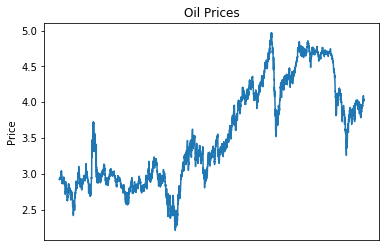

In [13]:
import matplotlib.pyplot as plt
plt.plot(tsdiff)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel('Price')
plt.title("Oil Prices")
plt.show()

In [14]:
df=pd.DataFrame(tsdiff)
df

,Price
0,2.924773
1,2.915064
2,2.920470
3,2.923162
4,2.924773
5,2.923162
6,2.923162
7,2.922086
8,2.925846
9,2.927453


In [15]:
# Form dataset matrix
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [16]:
df=np.array(df)

In [17]:
df

array([[2.92477318],
       [2.91506437],
       [2.92046979],
       ...,
       [4.01638302],
       [4.01259206],
       [4.03636228]])

In [18]:
# normalize dataset with MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.25948897],
       [0.2559728 ],
       [0.25793044],
       ...,
       [0.6548291 ],
       [0.65345615],
       [0.66206484]])

In [19]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# Training and Validation data partition
train_size = int(len(df) * 0.8)
val_size = len(df) - train_size
train, val = df[0:train_size,:], df[train_size:len(df),:]

# Number of previous
previous = 10
X_train, Y_train = create_dataset(train, previous)
X_val, Y_val = create_dataset(val, previous)

In [20]:
X_train

array([[0.25948897, 0.2559728 , 0.25793044, ..., 0.25851568, 0.25987756,
        0.26045966],
       [0.2559728 , 0.25793044, 0.25890531, ..., 0.25987756, 0.26045966,
        0.26181426],
       [0.25793044, 0.25890531, 0.25948897, ..., 0.26045966, 0.26181426,
        0.26239326],
       ...,
       [0.9070662 , 0.89714332, 0.90050332, ..., 0.91004565, 0.92053555,
        0.92331339],
       [0.89714332, 0.90050332, 0.89871076, ..., 0.92053555, 0.92331339,
        0.92315789],
       [0.90050332, 0.89871076, 0.903734  , ..., 0.92331339, 0.92315789,
        0.92156802]])

In [21]:
Y_train

array([0.26181426, 0.26239326, 0.25987756, ..., 0.92315789, 0.92156802,
       0.91325661])

Train on 4928 samples, validate on 1233 samples
Epoch 1/60
4928/4928 - 9s - loss: 0.0037 - val_loss: 0.0013
Epoch 2/60
4928/4928 - 8s - loss: 7.3354e-04 - val_loss: 0.0024
Epoch 3/60
4928/4928 - 8s - loss: 5.8314e-04 - val_loss: 0.0024
Epoch 4/60
4928/4928 - 8s - loss: 5.7166e-04 - val_loss: 5.5062e-04
Epoch 5/60
4928/4928 - 8s - loss: 4.9309e-04 - val_loss: 0.0027
Epoch 6/60
4928/4928 - 8s - loss: 4.7229e-04 - val_loss: 6.7254e-04
Epoch 7/60
4928/4928 - 8s - loss: 4.8205e-04 - val_loss: 0.0023
Epoch 8/60
4928/4928 - 8s - loss: 4.8510e-04 - val_loss: 8.8350e-04
Epoch 9/60
4928/4928 - 8s - loss: 5.0170e-04 - val_loss: 8.5736e-04
Epoch 10/60
4928/4928 - 8s - loss: 4.5332e-04 - val_loss: 4.0680e-04
Epoch 11/60
4928/4928 - 8s - loss: 4.8735e-04 - val_loss: 9.7858e-04
Epoch 12/60
4928/4928 - 8s - loss: 4.5997e-04 - val_loss: 4.4442e-04
Epoch 13/60
4928/4928 - 8s - loss: 4.9402e-04 - val_loss: 0.0013
Epoch 14/60
4928/4928 - 8s - loss: 4.8259e-04 - val_loss: 0.0026
Epoch 15/60
4928/4928 - 8s 

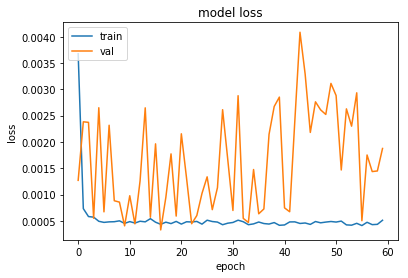

In [22]:
from tensorflow.keras.layers import Dropout

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Generate LSTM network
model = tf.keras.Sequential()
model.add(LSTM(4, input_shape=(1, previous)))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, Y_train, validation_split=0.2, epochs=60, batch_size=1, verbose=2)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Generate predictions
trainpred = model.predict(X_train)
valpred = model.predict(X_val)

In [24]:
trainpred

array([[0.2615492 ],
       [0.2628366 ],
       [0.26350605],
       ...,
       [0.8504038 ],
       [0.8493109 ],
       [0.84828675]], dtype=float32)

In [25]:
valpred

array([[0.8470993 ],
       [0.83846486],
       [0.83531535],
       ...,
       [0.6502234 ],
       [0.65554166],
       [0.6495342 ]], dtype=float32)

In [26]:
# Convert predictions back to normal values
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
valpred = scaler.inverse_transform(valpred)
Y_val = scaler.inverse_transform([Y_val])
predictions = valpred

In [27]:
import math
from sklearn.metrics import mean_squared_error

# calculate RMSE
trainScore = math.sqrt(mean_squared_error(Y_train[0], trainpred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(Y_val[0], valpred[:,0]))
print('Validation Score: %.2f RMSE' % (valScore))

Train Score: 0.06 RMSE
Validation Score: 0.13 RMSE


In [28]:
# Train predictions
trainpredPlot = np.empty_like(df)
trainpredPlot[:, :] = np.nan
trainpredPlot[previous:len(trainpred)+previous, :] = trainpred

In [29]:
# Validation predictions
valpredPlot = np.empty_like(df)
valpredPlot[:, :] = np.nan
valpredPlot[len(trainpred)+(previous*2)+1:len(df)-1, :] = valpred

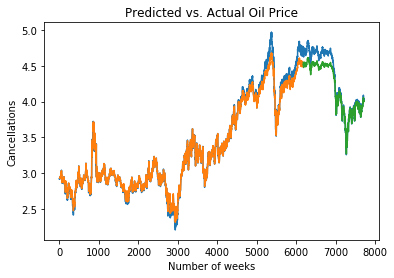

In [30]:
# Plot all predictions
inversetransform, =plt.plot(scaler.inverse_transform(df))
trainpred, =plt.plot(trainpredPlot)
valpred, =plt.plot(valpredPlot)
plt.xlabel('Number of weeks')
plt.ylabel('Cancellations')
plt.title("Predicted vs. Actual Oil Price")
plt.show()

In [31]:
Y_val=Y_val.reshape(-1)
Y_val.shape
Y_val=pd.Series(Y_val)

In [32]:
Y_val

0       4.693273
1       4.692906
2       4.681205
3       4.696290
4       4.686934
5       4.673576
6       4.657952
7       4.640634
8       4.623403
9       4.642177
10      4.648038
11      4.668708
12      4.695833
13      4.693364
14      4.722420
15      4.722509
16      4.739089
17      4.726680
18      4.719213
19      4.716354
20      4.691348
21      4.714921
22      4.715548
23      4.719481
24      4.704382
25      4.722509
26      4.700571
27      4.686105
28      4.672548
29      4.707907
          ...   
1503    3.944297
1504    3.949511
1505    3.964426
1506    3.973118
1507    3.962716
1508    3.982109
1509    3.997834
1510    3.991943
1511    3.999118
1512    3.992681
1513    4.008423
1514    4.016743
1515    4.038832
1516    4.028561
1517    4.016383
1518    4.035656
1519    4.046554
1520    4.055777
1521    4.063198
1522    4.084631
1523    4.090504
1524    4.073121
1525    4.074142
1526    4.043402
1527    4.019441
1528    4.027492
1529    4.025352
1530    4.0446

In [33]:
predictions=predictions.reshape(-1)
predictions.shape
predictions=pd.Series(predictions)

In [34]:
predictions

0       4.547278
1       4.523437
2       4.514740
3       4.509846
4       4.518194
5       4.516447
6       4.505855
7       4.497197
8       4.486683
9       4.477047
10      4.481396
11      4.488069
12      4.498343
13      4.516113
14      4.517261
15      4.531467
16      4.533111
17      4.539652
18      4.533735
19      4.527338
20      4.527316
21      4.513972
22      4.525717
23      4.528397
24      4.532119
25      4.524909
26      4.532589
27      4.526021
28      4.512645
29      4.504659
          ...   
1503    3.932858
1504    3.929767
1505    3.932732
1506    3.944990
1507    3.955415
1508    3.948978
1509    3.960449
1510    3.975327
1511    3.973744
1512    3.976664
1513    3.972579
1514    3.983723
1515    3.992794
1516    4.009455
1517    4.005824
1518    3.994701
1519    4.007650
1520    4.018502
1521    4.027373
1522    4.032056
1523    4.049046
1524    4.057826
1525    4.046291
1526    4.042827
1527    4.021167
1528    4.000082
1529    4.002300
1530    4.0036

In [35]:
import numpy as np

def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

In [36]:
mda(Y_val, predictions)

0.9986953685583823

In [37]:
# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/

from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(Y_val, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 0.128350


In [38]:
forecast_error = (predictions-Y_val)
forecast_error

0      -0.145995
1      -0.169470
2      -0.166465
3      -0.186444
4      -0.168740
5      -0.157129
6      -0.152097
7      -0.143437
8      -0.136720
9      -0.165129
10     -0.166642
11     -0.180640
12     -0.197491
13     -0.177251
14     -0.205159
15     -0.191041
16     -0.205978
17     -0.187028
18     -0.185478
19     -0.189016
20     -0.164032
21     -0.200949
22     -0.189831
23     -0.191084
24     -0.172263
25     -0.197600
26     -0.167982
27     -0.160083
28     -0.159903
29     -0.203248
          ...   
1503   -0.011439
1504   -0.019744
1505   -0.031694
1506   -0.028128
1507   -0.007301
1508   -0.033130
1509   -0.037385
1510   -0.016616
1511   -0.025374
1512   -0.016017
1513   -0.035844
1514   -0.033021
1515   -0.046038
1516   -0.019106
1517   -0.010559
1518   -0.040955
1519   -0.038904
1520   -0.037275
1521   -0.035825
1522   -0.052575
1523   -0.041458
1524   -0.015295
1525   -0.027851
1526   -0.000575
1527    0.001725
1528   -0.027410
1529   -0.023052
1530   -0.0409

In [39]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-0.09622478646512134

In [40]:
# Predict last 10 days of oil prices using t-10
Xnew = np.array([[57.93,
60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42],[60.68,
62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59],[62.7,
61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29],[61.28,
63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25],[63.99,
64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23],[64.67,
63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23,
64.66],[63.02,
60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23,
64.66,
64.13],[60.76,
61.25,
68.42,
65.59,
64.29,
64.25,
65.23,
64.66,
64.13,
62.41],[61.25,
68.42,
65.59,
64.29,
64.25,
65.23,
64.66,
64.13,
62.41,
62.08],[68.42,
65.59,
64.29,
64.25,
65.23,
64.66,
64.13,
62.41,
62.08,
62.48]])

In [41]:
Xnew

array([[57.93, 60.68, 62.7 , 61.28, 63.99, 64.67, 63.02, 60.76, 61.25,
        68.42],
       [60.68, 62.7 , 61.28, 63.99, 64.67, 63.02, 60.76, 61.25, 68.42,
        65.59],
       [62.7 , 61.28, 63.99, 64.67, 63.02, 60.76, 61.25, 68.42, 65.59,
        64.29],
       [61.28, 63.99, 64.67, 63.02, 60.76, 61.25, 68.42, 65.59, 64.29,
        64.25],
       [63.99, 64.67, 63.02, 60.76, 61.25, 68.42, 65.59, 64.29, 64.25,
        65.23],
       [64.67, 63.02, 60.76, 61.25, 68.42, 65.59, 64.29, 64.25, 65.23,
        64.66],
       [63.02, 60.76, 61.25, 68.42, 65.59, 64.29, 64.25, 65.23, 64.66,
        64.13],
       [60.76, 61.25, 68.42, 65.59, 64.29, 64.25, 65.23, 64.66, 64.13,
        62.41],
       [61.25, 68.42, 65.59, 64.29, 64.25, 65.23, 64.66, 64.13, 62.41,
        62.08],
       [68.42, 65.59, 64.29, 64.25, 65.23, 64.66, 64.13, 62.41, 62.08,
        62.48]])

In [42]:
Xnew = scaler.fit_transform(Xnew)
Xnew
Xnewformat = np.reshape(Xnew, (Xnew.shape[0], 1, Xnew.shape[1]))
ynew=model.predict(Xnewformat)

In [43]:
Xnew.shape

(10, 10)

In [44]:
ynew

array([[0.76512206],
       [0.6051904 ],
       [0.41791713],
       [0.34282342],
       [0.43717358],
       [0.4258473 ],
       [0.34965914],
       [0.15762065],
       [0.05851173],
       [0.07275078]], dtype=float32)

In [45]:
type(ynew)

numpy.ndarray

In [46]:
ynew.shape

(10, 1)

In [47]:
actual = np.array([[65.59,
64.29,
64.25,
65.23,
64.66,
64.13,
62.41,
62.08,
62.48,
60.99
]])

In [48]:
actual=actual.reshape(10,-1)
actual.shape

(10, 1)

In [49]:
actual

array([[65.59],
       [64.29],
       [64.25],
       [65.23],
       [64.66],
       [64.13],
       [62.41],
       [62.08],
       [62.48],
       [60.99]])

In [50]:
ynew=ynew.reshape(-1)
actual=actual.reshape(-1)
actualpd=pd.Series(actual)

In [51]:
np.min(df)

0.0

In [52]:
ynew

array([0.76512206, 0.6051904 , 0.41791713, 0.34282342, 0.43717358,
       0.4258473 , 0.34965914, 0.15762065, 0.05851173, 0.07275078],
      dtype=float32)

In [53]:
maxoil=np.max(tseries)

In [54]:
minoil=np.min(tseries)

In [55]:
ynew = ynew * np.abs(maxoil-minoil) + np.min(tseries)
ynewpd=pd.Series(ynew)

In [56]:
actualpd

0    65.59
1    64.29
2    64.25
3    65.23
4    64.66
5    64.13
6    62.41
7    62.08
8    62.48
9    60.99
dtype: float64

In [57]:
ynewpd

0    112.276711
1     90.709930
2     65.456131
3     55.329742
4     68.052856
5     66.525513
6     56.251541
7     30.355146
8     16.990309
9     18.910442
dtype: float32

In [58]:
mda(actualpd, ynewpd)

0.8

In [59]:
mse = mean_squared_error(actualpd, ynewpd)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 28.069157


In [60]:
forecast_error = (ynewpd-actualpd)
forecast_error

0    46.686711
1    26.419930
2     1.206131
3    -9.900258
4     3.392856
5     2.395513
6    -6.158459
7   -31.724854
8   -45.489691
9   -42.079558
dtype: float64

In [61]:
mean_forecast_error = np.mean(forecast_error)
mean_forecast_error

-5.525167785644531

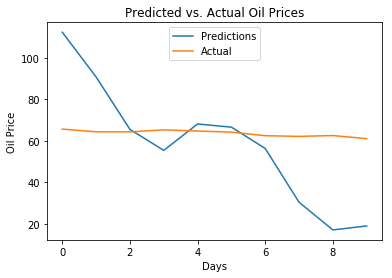

In [62]:
predictons, =plt.plot(ynewpd, label='Predictions')
actual, =plt.plot(actualpd, label='Actual')
plt.xlabel('Days')
plt.ylabel('Oil Price')
plt.title("Predicted vs. Actual Oil Prices")
plt.legend(loc = 'upper center')
plt.show()